In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import sys
from copy import deepcopy
import pickle as pkl

from ex_cosmology import p
from matplotlib import gridspec

# adaptive-wavelets modules
sys.path.append('../..')
from src.mdata.cosmology import get_dataloader, load_pretrained_model
from src.mdata.cosmology import get_validation
from src.adaptive_wavelets.utils import tuple_to_tensor, tensor_to_tuple
from src import adaptive_wavelets
from src.trim import TrimModel

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount, rmse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [5]:
dirs = [
        "db5_saliency_warmstart_seed=1_new"
        ]
dics, _, _ = load_results(dirs)

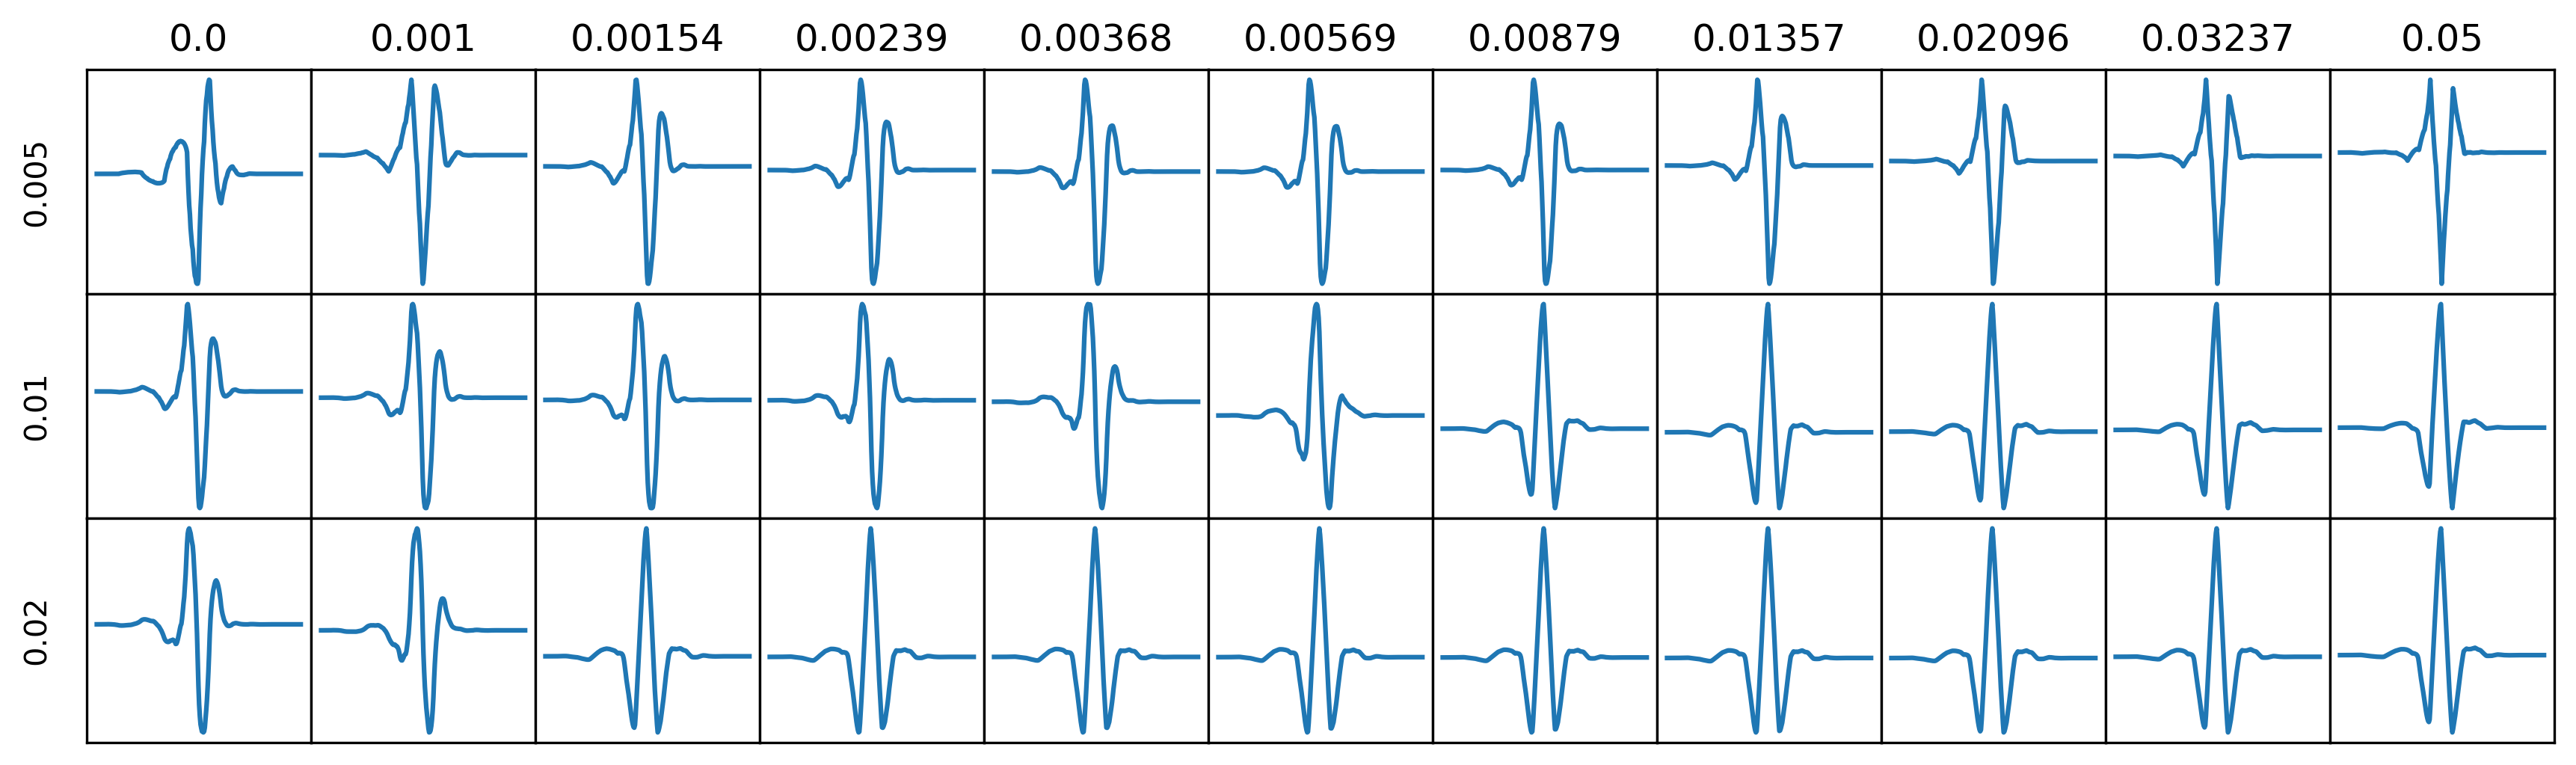

In [6]:
index = 0 # select which result to display
lamwaves = np.fromiter(dics[index]['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dics[index]['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
R = len(lamwaves)
C = len(lamattrs)

plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))  

for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(dics[index]['x'][(r,c)], dics[index]['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))

# plt.savefig('figures/cosmo_wave_vary.pdf', bbox_inches='tight')

In [7]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path, 
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)   

# validation dataset
test_loader = get_validation(p.data_path, 
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# select optimal bin using heldout dataset

In [19]:
# # DB5
wt_o = adaptive_wavelets.DWT2d(wave='db5', mode='zero', J=4, 
                               init_factor=1, noise_factor=0, const_factor=0)

# # extract kernels
# kern_list = []
# for wt in [wt_o] + list(dics[0]['wt'].values()):
#     filt = adaptive_wavelets.get_2dfilts(wt)
#     h = filt[0][0]
#     g = filt[0][1]
#     kern_list.append(extract_patches(h, g))
    
bds = np.linspace(0.015,0.035,5)
# scores = np.zeros((len(bds), len(kern_list)))  

# for i,b in enumerate(bds):
#     for j,kernels in enumerate(kern_list):
#         pcw = PeakCount(peak_counting_method='custom', 
#                         bins=np.linspace(0,b,23),
#                         kernels=kernels)
#         pcw.fit(train_loader)
#         y_preds, y_params = pcw.predict(val_loader)
#         scores[i,j] = rmse(y_params, y_preds)
#         pkl.dump(scores, open('results/scores_new.pkl', 'wb'))  
#         print(
#             "\riteration bd={}/{} kern={}/{}".format(
#                 i + 1, len(bds), j + 1, len(kern_list)
#             ),
#             end="",
#         )        
        
# print('\n', np.min(scores))

# optimal filter

In [45]:
# load optimal wavelet for prediction on heldout dataset
scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col+1] ## NEED TO CHECK
# idx2 = 4
wt = dics[0]['wt'][(idx1, idx2)]   
lamL1wave = dics[0]['lamL1wave'][(idx1, idx2)]
lamL1attr = dics[0]['lamL1attr'][(idx1, idx2)]
print('lambda: {} gamma: {}'.format(lamL1wave, lamL1attr))

# AWD prediction performance
filt = adaptive_wavelets.get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bd_opt,23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("AWD: ", acc, std)

# original wavelet prediction performance
filt = adaptive_wavelets.get_2dfilts(wt_o)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bds[np.argmin(scores[:,0])],23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(test_loader)
acc, std = rmse_bootstrap(y_preds, y_params)
print("DB5: ", acc, std)

lambda: 0.02 gamma: 0.00368
AWD:  0.01028726999170842 0.00033492254696672005
DB5:  0.015692681086327664 0.00048067312692403594


# compression

In [ ]:
device = 'cpu'

# define trim model
mt = TrimModel(model, wt.inverse, use_residuals=True)    
mt_o = TrimModel(model, wt_o.inverse, use_residuals=True)  
attributer = adaptive_wavelets.Attributer(mt, attr_methods='Saliency', device=device)
attributer_o = adaptive_wavelets.Attributer(mt_o, attr_methods='Saliency', device=device)

# compute compression rate and representations
attrs = {'AWD': torch.tensor([]),
         'DB5': torch.tensor([])}
reps = {'AWD': torch.tensor([]),
        'DB5': torch.tensor([])}
wt, wt_o = wt.to(device), wt_o.to(device)
for data, _ in test_loader:
    data = data.to(device)
    i = 0
    for w in [wt, wt_o]:
        if i == 0:
            data_t = w(data)
            with torch.backends.cudnn.flags(enabled=False):
                attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))   
            y, _ = tuple_to_tensor(data_t)
            reps['AWD'] = torch.cat((reps['AWD'], y.detach().cpu()), dim=0)
            z, _ = tuple_to_tensor(attributions)
            attrs['AWD'] = torch.cat((attrs['AWD'], z.detach().cpu()), dim=0)
        else:
            data_t = w(data)
            with torch.backends.cudnn.flags(enabled=False):
                attributions = attributer_o(data_t, target=0, additional_forward_args=deepcopy(data))   
            y, _ = tuple_to_tensor(data_t)
            reps['DB5'] = torch.cat((reps['DB5'], y.detach().cpu()), dim=0)
            z, _ = tuple_to_tensor(attributions)
            attrs['DB5'] = torch.cat((attrs['DB5'], z.detach().cpu()), dim=0)
        i += 1
reps['AWD'] = reps['AWD'].reshape(-1)
reps['DB5'] = reps['DB5'].reshape(-1) 
attrs['AWD'] = attrs['AWD'].reshape(-1)
attrs['DB5'] = attrs['DB5'].reshape(-1) 

thresh1 = 1e-3
thresh2 = 1e-3
c_rate_AWD = 1.0*((abs(reps['AWD']) > thresh1) & (abs(attrs['AWD']) > thresh2)).sum() / reps['AWD'].shape[0]
c_rate_DB5 = 1.0*((abs(reps['DB5']) > thresh1) & (abs(attrs['DB5']) > thresh2)).sum() / reps['DB5'].shape[0]
print(c_rate_AWD.item(), c_rate_DB5.item())

# viz importance features

In [ ]:
def create_mask(attributions: tuple, num):
    """ 
    Threshold attributions retaining those with top absolute attributions 
    """    
    batch_size = attributions[0].shape[0]
    J = len(attributions)
    b = torch.tensor([]).to(device)
    list_of_size = [0]    
    for j in range(J):
        a = abs(attributions[j]).reshape(batch_size, -1)
        b = torch.cat((b,a), dim=1)
        list_of_size.append(list_of_size[-1] + a.shape[1])
    sort_indexes = torch.argsort(b, dim=1, descending=True)      
    
    m = torch.zeros_like(sort_indexes)
    for i in range(batch_size):
        m[i][sort_indexes[i,:num]] = 1

    list_of_masks = []
    for j in range(J):
        n0 = list_of_size[j]
        n1 = list_of_size[j+1]
        list_of_masks.append(m[:,n0:n1].reshape(attributions[j].shape))

    return list_of_masks

In [ ]:
# trim model
mt = TrimModel(model, wt.inverse, use_residuals=True) 
attributer = adaptive_wavelets.Attributer(mt, attr_methods='IntegratedGradient', device=device)

# data
torch.manual_seed(2) 
data = iter(train_loader).next()[0].to(device)
num = 600

# plot
num_rows = 5
num_cols = 2
titsize = 6

fig = plt.figure(dpi=300, figsize=(2,4))

for j in range(5):
    # AWD
    data_t = wt(data[j:j+1])
    attributions = attributer(data_t, target=1, additional_forward_args=deepcopy(data)) 
    mask = create_mask(attributions, num)
    m = ()
    for i,a in enumerate(data_t):
        m += (a * mask[i],)
    data_orig = data[j:j+1]
    data_mask = wt.inverse(m)

    im1 = data_orig.detach().squeeze().cpu().numpy()
    im2 = data_mask.detach().squeeze().cpu().numpy()
    
    plt.subplot(num_rows, num_cols, j*num_cols + 1)
    plt.imshow(im1, cmap='magma', vmax=0.15, vmin=-0.05)
    plt.axis('off')
    if j == 0:
        plt.title('Original image', fontsize=titsize)
        
    plt.subplot(num_rows, num_cols, j*num_cols + 2)
    plt.imshow(im2, cmap='magma', vmax=0.15, vmin=-0.05)
    plt.axis('off') 
    if j == 0:
        plt.title('Activation map', fontsize=titsize)    
        
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2, hspace=0.05)

# plt.savefig('figures/cosmo_act_map.pdf', bbox_inches='tight')

activation map in the pixel domain

In [ ]:
# trim model
mt = TrimModel(model, wt.inverse, use_residuals=True) 
attributer = adaptive_wavelets.Attributer(mt, attr_methods='IntegratedGradient', device=device)

# data
torch.manual_seed(2) 
data = iter(train_loader).next()[0].to(device)
num = 600

# plot
num_rows = 5
num_cols = 2
titsize = 6

fig = plt.figure(dpi=300, figsize=(2,4))

for j in range(5):
    # AWD
    data_t = wt(data[j:j+1])
    attributions = attributer(data_t, target=1, additional_forward_args=deepcopy(data)) 
    mask = create_mask(attributions, num)
    m = ()
    for i,a in enumerate(data_t):
        m += (a * mask[i],)
    data_orig = data[j:j+1]
    data_mask = wt.inverse(m)

    im1 = data_orig.detach().squeeze().cpu().numpy()
    im2 = data_mask.detach().squeeze().cpu().numpy()
    
    plt.subplot(num_rows, num_cols, j*num_cols + 1)
    plt.imshow(im1, cmap='magma', vmax=0.15, vmin=-0.05)
    plt.axis('off')
    if j == 0:
        plt.title('Original image', fontsize=titsize)
        
    plt.subplot(num_rows, num_cols, j*num_cols + 2)
    plt.imshow(im2, cmap='magma', vmax=0.15, vmin=-0.05)
    plt.axis('off') 
    if j == 0:
        plt.title('Activation map', fontsize=titsize)    
        
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2, hspace=0.05)

# plt.savefig('figures/cosmo_act_map.pdf', bbox_inches='tight')